# Run Sandwich Attacks on Swaps from the Public Mempool

In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import os
import sys
import math

current_path = sys.path[0]
sys.path.append(
    current_path[: current_path.find("defi-measurement")]
    + "liquidity-distribution-history"
)

sys.path.append("..")

import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from datetime import datetime, timezone


# Set display options
pd.set_option("display.max_colwidth", None)  # Display entire cell content
pd.set_option("display.max_rows", 50)  # Display all rows
pd.set_option("display.max_columns", None)  # Display all columns


from dotenv import load_dotenv
from pool_state import v3Pool
from sqlalchemy import create_engine
from tqdm import tqdm

from moralis import evm_api


load_dotenv(override=True)
# from experiments.random_permutations import load_pool

from experiments.preload_pool_cache import load_pool_from_blob
from experiments.calculate_simple_sandwich import (
    get_data,
    SwapData,
    single_sandwich_mev,
    max_frontrun,
    auto_sandwich_mev,
    SimpleSandwich,
)


from decimal import getcontext

getcontext().prec = 100  # Set the precision high enough for our purposes


# Read in the environment variables
postgres_uri_mp = os.environ["POSTGRESQL_URI_MP"]
postgres_uri_us = os.environ["POSTGRESQL_URI_US"]
azure_storage_uri = os.environ["AZURE_STORAGE_CONNECTION_STRING"]
moralis_api_key = os.environ["MORALIS_API_KEY"]

## Get the Data

### Populate the swap data we have with the block number that the swap appeared in

In [3]:
df = get_data()

df.head()

amountIn  \
pool                                       block_number                
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17552211.0     3200000000   
                                           17552242.0      303798589   
                                           17552250.0    16102020684   
                                           17552252.0     6543850000   
                                           17552278.0      150000000   

                                                                amountOutMin  \
pool                                       block_number                        
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17552211.0    1608133671221393483   
                                           17552242.0     160355281886090203   
                                           17552250.0    8532306101844837653   
                                           17552252.0    3467552154643320542   
                                           17552278.0      79798648054443290   

                                                                                             token0  \
pool                                       block_number                                               
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17552211.0    0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   
                                           17552242.0    0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   
                                           17552250.0    0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   
                                           17552252.0    0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   
                                           17552278.0    0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   

                                                         fee  \
pool                                       block_number        
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17552211.0    500   
                                           17552242.0    500   
                                           17552250.0    500   
                                           17552252.0    500   
                                           17552278.0    500   

                                                                                             token1  \
pool                                       block_number                                               
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17552211.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
                                           17552242.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
                                           17552250.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
                                           17552252.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
                                           17552278.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   

                                                                                                                       hash  \
pool                                       block_number                                                                       
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17552211.0    0xcccbb87fc3e5e2b7851adc2140f46603c39eebef648048d59904987f47a9aa50   
                                           17552242.0    0x4c1da0dcc8367691658daa4bf50af22df275e8898975edfb96c65625da07098d   
                                           17552250.0    0x94f9a95e35ef12f68ce0b4aa1a40a15e8f72472f5af549fc90dc884909db6522   
                                           17552252.0    0xc708f2903a47f281da6eaa12ea3e35f5c396a2567e3f7478058c1102a11f2bd4   
                                           17552278.0    0x3aebe0e7c4c49d9e98f394e4c5141b731ebf63c73a74b388bcb5258c61440fe3   

                                                                              first_seen  
pool                                       block_number                                   
0x88e6a0c2ddd26feeb64f039a2c4

## Get a pool and do some initial testing

In [4]:
swap_data = df[df.hash == '0x503ff2a5421b7a3e9594051eb933ad5ea01a9ccc0d76a41b5fc2df945af2a7f2']

swap = SwapData(**swap_data.reset_index().to_dict('records')[0]) # type: ignore

swap

SwapData(pool='0x78d4e81fc84a1ce367e90936e49a74a9052137e8', block_number=17578916.0, amountIn='10000000000000000000', amountOutMin='466622823911182083', token0='0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', fee='10000', token1='0x2890df158d76e584877a1d17a85fea3aeeb85aa6', hash='0x503ff2a5421b7a3e9594051eb933ad5ea01a9ccc0d76a41b5fc2df945af2a7f2', first_seen=Timestamp('2023-06-28 16:09:49.897000+0000', tz='UTC'))

In [5]:
pool = load_pool_from_blob(
    str(swap_data.index.get_level_values(0)[0]),
    postgres_uri_us,
    azure_storage_uri,
    "uniswap-v3-pool-cache",
    verbose=True,
    invalidate_before_date=datetime(2023, 8, 16, tzinfo=timezone.utc),
)

Loading pool from Azure blob storage cache


In [6]:
assert pool

max_frontrun(
    pool,
    swap,
    verbose=True,
)

0: Trying 1000000.0
1: Trying 2000000.0
2: Trying 4000000.0
3: Trying 8000000.0
4: Trying 16000000.0
5: Trying 32000000.0
6: Trying 64000000.0
7: Trying 128000000.0
8: Trying 256000000.0
9: Trying 512000000.0
10: Trying 1024000000.0
11: Trying 2048000000.0
12: Trying 4096000000.0
13: Trying 8192000000.0
14: Trying 16384000000.0
15: Trying 32768000000.0
16: Trying 65536000000.0
17: Trying 131072000000.0
18: Trying 262144000000.0
19: Trying 524288000000.0
20: Trying 1048576000000.0
21: Trying 2097152000000.0
22: Trying 4194304000000.0
23: Trying 8388608000000.0
24: Trying 16777216000000.0
25: Trying 33554432000000.0
26: Trying 67108864000000.0
27: Trying 134217728000000.0
28: Trying 268435456000000.0
29: Trying 536870912000000.0
30: Trying 1073741824000000.0
31: Trying 2147483648000000.0
32: Trying 4294967296000000.0
33: Trying 8589934592000000.0
34: Trying 1.7179869184e+16
35: Trying 3.4359738368e+16
36: Trying 6.8719476736e+16
37: Trying 1.37438953472e+17
38: Trying 2.74877906944e+17
0

2.72994664448e+17

In [8]:
assert pool is not None

profit, gas, prices = single_sandwich_mev(
    pool,
    swap,
    int(2.72994664448e+17),
    pool_fee=True,
)

print(f"Profit: {profit / 1e18}")
print(f"Gas: {gas}")
print(f"Prices: {prices}")

Profit: 0.003185129981081248
Gas: 0.006719305386569982
Prices: (4.56768883595478, 4.569668914667892, 4.642682234572798, 4.64065881939532)


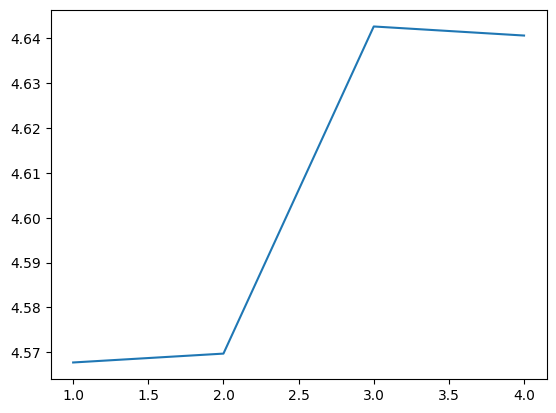

In [9]:
plt.plot([1,2,3,4], prices);

In [16]:
# See if the profit of the profitable attack is maximized by inserting the maximum size frontrunning swap

xs = []
ys = []

inp = 1e12

while inp <= int(2.72994664448e+19):
    print(f"Running {inp:.2e} <= 2.73e+19")
    profit, gas, prices = single_sandwich_mev(
        pool,
        swap,
        int(inp),
        pool_fee=True,
    )

    xs.append(inp)
    ys.append(profit)

    inp *= 2

Running 1.00e+12 <= 2.73e+19
Running 2.00e+12 <= 2.73e+19
Running 4.00e+12 <= 2.73e+19
Running 8.00e+12 <= 2.73e+19
Running 1.60e+13 <= 2.73e+19
Running 3.20e+13 <= 2.73e+19
Running 6.40e+13 <= 2.73e+19
Running 1.28e+14 <= 2.73e+19
Running 2.56e+14 <= 2.73e+19
Running 5.12e+14 <= 2.73e+19
Running 1.02e+15 <= 2.73e+19
Running 2.05e+15 <= 2.73e+19
Running 4.10e+15 <= 2.73e+19
Running 8.19e+15 <= 2.73e+19
Running 1.64e+16 <= 2.73e+19
Running 3.28e+16 <= 2.73e+19
Running 6.55e+16 <= 2.73e+19
Running 1.31e+17 <= 2.73e+19
Running 2.62e+17 <= 2.73e+19
Running 5.24e+17 <= 2.73e+19
Running 1.05e+18 <= 2.73e+19
Running 2.10e+18 <= 2.73e+19
Running 4.19e+18 <= 2.73e+19
Running 8.39e+18 <= 2.73e+19
Running 1.68e+19 <= 2.73e+19


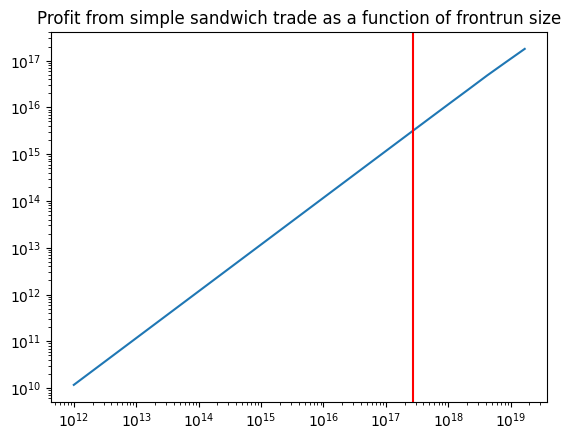

In [22]:
plt.plot(xs, ys)
plt.loglog()
plt.axvline(x=2.72994664448e+17, color='red')
plt.title('Profit from simple sandwich trade as a function of frontrun size');

In [40]:
assert pool is not None

auto_sandwich_mev(
    pool,
    swap,
    start=1e12,
    factor=10,
    pool_fee=True,
    verbose=True,
)

0: Trying 1000000.0
1: Trying 10000000.0
2: Trying 100000000.0
3: Trying 1000000000.0
4: Trying 10000000000.0
5: Trying 100000000000.0
6: Trying 1000000000000.0
7: Trying 10000000000000.0
0: Trying 1000000000000.0 - 10000000000000.0
1: Trying 5500000000000.0 - 10000000000000.0
2: Trying 5500000000000.0 - 7750000000000.0
3: Trying 5500000000000.0 - 6625000000000.0
4: Trying 6062500000000.0 - 6625000000000.0
5: Trying 6343750000000.0 - 6625000000000.0
6: Trying 6343750000000.0 - 6484375000000.0
7: Trying 6343750000000.0 - 6414062500000.0
8: Trying 6343750000000.0 - 6378906250000.0
9: Trying 6343750000000.0 - 6361328125000.0
10: Trying 6352539062500.0 - 6361328125000.0
11: Trying 6352539062500.0 - 6356933593750.0
12: Trying 6352539062500.0 - 6354736328125.0
13: Trying 6352539062500.0 - 6353637695312.0
14: Trying 6352539062500.0 - 6353088378906.0
15: Trying 6352813720703.0 - 6353088378906.0
16: Trying 6352951049804.0 - 6353088378906.0
17: Trying 6353019714355.0 - 6353088378906.0
18: Trying

AutoSandwichResult(profit=-6284193032.0, gas_fee=0.007010483569918752, frontrun_input=6353019714355.0, price_baseline=4.3577930944809406e-05, price_frontrun=4.4178991727856794e-05, price_user=4.417908996981208e-05, price_backrun=4.35782501103994e-05)

## Inspect the sandwiches created

In [3]:
engine = create_engine(postgres_uri_mp)

In [6]:

sw = pd.read_sql_query(
    """
    SELECT * FROM simple_sandwiches
    """,
    engine,
)

sw.shape

(36498, 21)

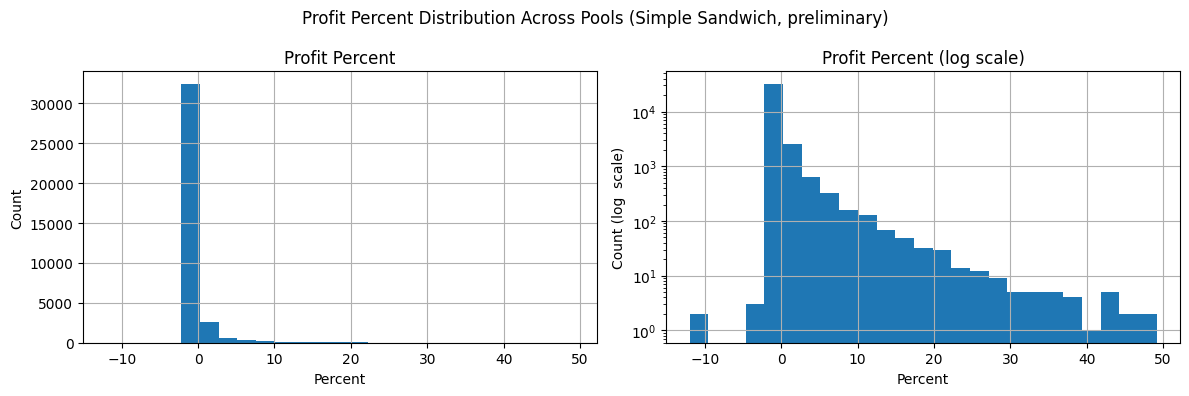

In [7]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

profits = sw.profit_percent
profits = profits[(profits < .5) & (profits > -.5)]

(profits * 100).hist(bins=25, ax=ax1)
(profits * 100).hist(bins=25, ax=ax2)

# Make log y axis
ax2.set_yscale('log')

# Set titles
ax1.set_title('Profit Percent')
ax2.set_title('Profit Percent (log scale)')

# Set x labels
ax1.set_xlabel('Percent')
ax2.set_xlabel('Percent')

# Set y labels
ax1.set_ylabel('Count')
ax2.set_ylabel('Count (log  scale)');

# Subtitle
plt.suptitle('Profit Percent Distribution Across Pools (Simple Sandwich, preliminary)');

plt.tight_layout()

In [16]:
sw = sw.assign(profit_profitable=sw.profit_percent.apply(lambda x: x if x > 0 else 0))
sw.profit_profitable.mean() * 100

0.8023819645501707

### Look at profitability relative to user swap size

In [8]:
sw.columns

Index(['user_hash', 'block_number', 'pool', 'token_in', 'token_out', 'profit',
       'profit_nofee', 'profit_float', 'profit_nofee_float', 'gas_fee_eth',
       'frontrun_input', 'price_baseline', 'price_frontrun', 'price_user',
       'price_backrun', 'profit_percent', 'frontrun_input_float', 'created_at',
       'user_input_float', 'profit_per_user_input', 'profit_usd'],
      dtype='object')

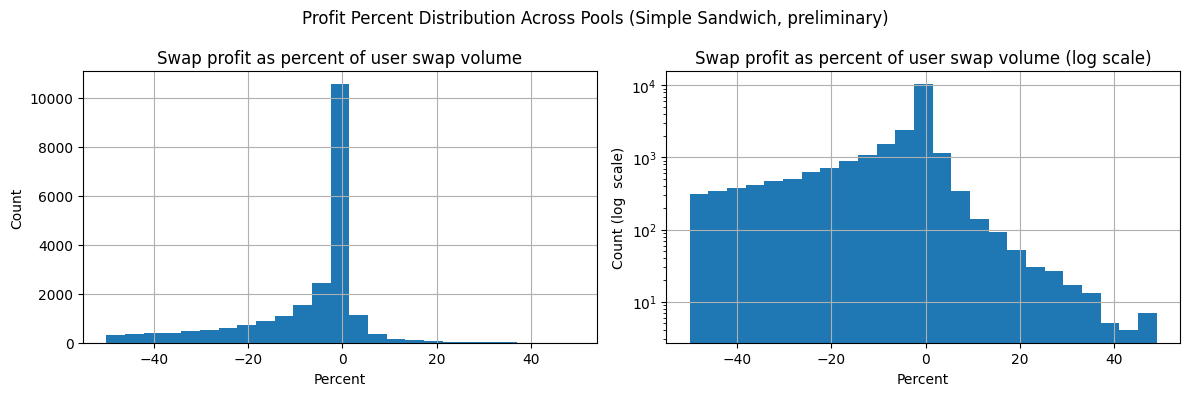

In [12]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

prof_per_input = sw.profit_per_user_input
prof_per_input = prof_per_input[(prof_per_input < .5) & (prof_per_input > -.5)]

(prof_per_input * 100).hist(bins=25, ax=ax1)
(prof_per_input * 100).hist(bins=25, ax=ax2)

# Make log y axis
ax2.set_yscale('log')

# Set titles
ax1.set_title('Swap profit as percent of user swap volume')
ax2.set_title('Swap profit as percent of user swap volume (log scale)')

# Set x labels
ax1.set_xlabel('Percent')
ax2.set_xlabel('Percent')

# Set y labels
ax1.set_ylabel('Count')
ax2.set_ylabel('Count (log  scale)');

# Subtitle
plt.suptitle('Profit Percent Distribution Across Pools (Simple Sandwich, preliminary)');

plt.tight_layout()

In [25]:
only_profitable_per_user_input = sw.profit_per_user_input.apply(lambda x: x if x > 0 else 0)
f"{only_profitable_per_user_input.mean() * 100:.2f}%"

'0.41%'

In [24]:
f"{sw.profit_float.apply(lambda x: x if x > 0 else 0).sum() / sw.user_input_float.sum():.2%}"

'0.89%'

### Look at what pools have the most profitable swaps

In [25]:
engine_us = create_engine(postgres_uri_us)

pool_info = pd.read_sql_query("SELECT * FROM token_info", engine_us).set_index('pool')

pool_info.head()

,block_timestamp,block_number,transaction_hash,log_index,token0,token1,fee,tick_spacing,token0symbol,decimals0,token1symbol,decimals1
pool,,,,,,,,,,,,
0x3ffedcddd268511acc44ae67845bdd56c8417fa4,2022-05-07 04:04:57+00:00,14727619,0x608b28353bd9e08824c450b60aeec0e24fdf8921049aa0acbc79c2276d0689f9,222,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0x419d0d8bdd9af5e606ae2232ed285aff190e711b,100,1,WBTC,8.0,FUN,8.0
0xf8bc8c39a82506dc0709e626b2e882a014bb9838,2023-04-12 09:52:35+00:00,17031160,0x8c84ecaabba61d00af64fe4f272404d52cb06f60656ce0c1d467934f8fbed168,236,0x2b591e99afe9f32eaa6214f7b7629768c40eeb39,0x66a0f676479cee1d7373f3dc2e2952778bff5bd6,100,1,HEX,8.0,WISE,18.0
0xe82c5c1ec82124ddf833800a3b61a3ec7106b18b,2021-11-13 07:18:03+00:00,13606313,0x505efb367d2a29b2ddc89f38f36a20216238cd30673bab9847f3333e22a4945a,307,0x056fd409e1d7a124bd7017459dfea2f387b6d5cd,0x6b175474e89094c44da98b954eedeac495271d0f,100,1,GUSD,2.0,DAI,18.0
0x75bff91af9878f5ec3fede9b52d51159afc2430a,2022-05-07 04:20:49+00:00,14727691,0x2e3cc9a2dfa8d48930054952a844bef7303304250b738a445b9e1d1483c70f0b,371,0x419d0d8bdd9af5e606ae2232ed285aff190e711b,0x6b175474e89094c44da98b954eedeac495271d0f,100,1,FUN,8.0,DAI,18.0
0xd1000344c3a00846462b4624bb452621cf2ce001,2021-11-13 07:18:03+00:00,13606313,0xf9d2dab791e3a006f2ffdade52cbf6c4a8c49a9c8cba5dbe4793014d5e2b2d76,301,0x4fabb145d64652a948d72533023f6e7a623c7c53,0x6b175474e89094c44da98b954eedeac495271d0f,100,1,BUSD,18.0,DAI,18.0


In [ ]:
pool_info = pool_info.assign(pool_name=pool_info.apply(lambda x: f"{x['token0symbol']}-{x['token1symbol']}", axis=1))

pool_info = pool_info[['pool_name']]

In [30]:
sw = pd.merge(sw, pool_info, on='pool', how='left')

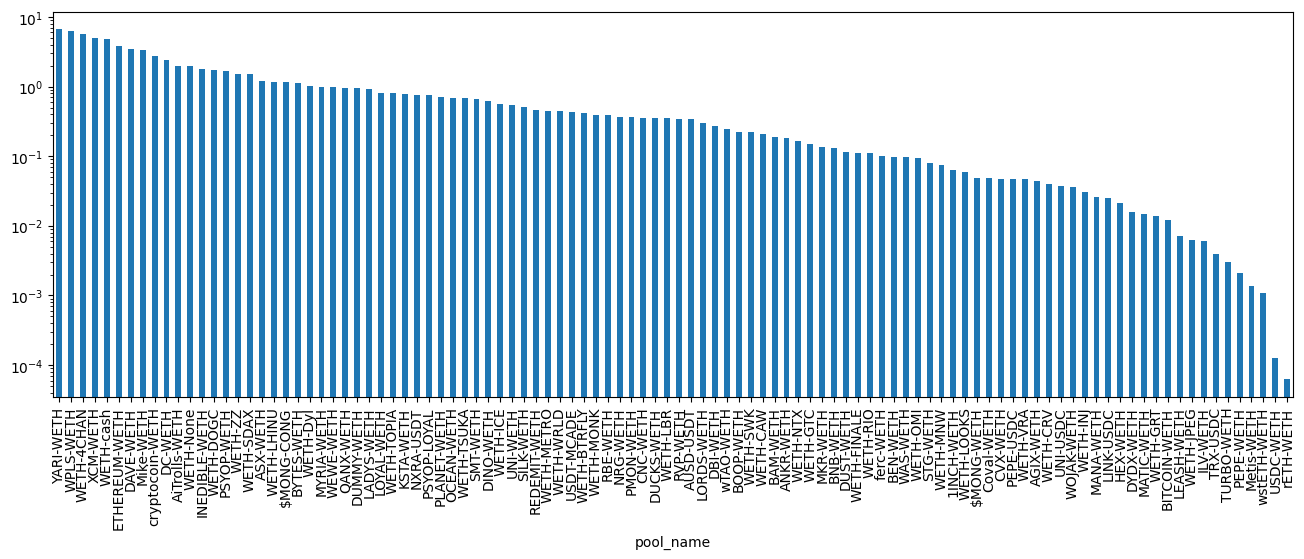

In [31]:
_, ax = plt.subplots(figsize=(16, 5))
mean_per_pool = sw.groupby('pool_name').profit_profitable.mean()
(mean_per_pool[mean_per_pool > 0] * 100).sort_values(ascending=False).plot.bar(ax=ax)

ax.set_yscale('log');

## Add profit values in USD

In [28]:
from sqlalchemy import create_engine, Column, String, Float, Integer, MetaData, Table
from sqlalchemy.orm import sessionmaker

SessionLocal = sessionmaker(bind=engine)

In [29]:
engine_us = create_engine(postgres_uri_us)

token_info = pd.read_sql_table('token_info', engine_us)

token_info0 = token_info[["token0", "decimals0"]].rename(columns={"token0": "token", "decimals0": "decimals"})
token_info1 = token_info[["token1", "decimals1"]].rename(columns={"token1": "token", "decimals1": "decimals"})

token_info = pd.concat([token_info0, token_info1], ignore_index=True).drop_duplicates().reset_index(drop=True).set_index("token")

token_info = token_info.dropna()

,decimals
token,
0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,8.0
0x2b591e99afe9f32eaa6214f7b7629768c40eeb39,8.0
0x056fd409e1d7a124bd7017459dfea2f387b6d5cd,2.0
0x419d0d8bdd9af5e606ae2232ed285aff190e711b,8.0
0x4fabb145d64652a948d72533023f6e7a623c7c53,18.0
...,...
0xe47c9edd0c2ec87c4a60b164f0564ef897e338fb,18.0
0xed21adccd7fb37d94114b211cb9ee7d602dfdb3f,2.0
0xf55b21f5bc66493d0abd269537e97f6b79da2b8a,18.0


In [32]:
session = SessionLocal()


rows = session.query(SimpleSandwich).filter(SimpleSandwich.profit_usd == None).all()

errors = 0
it = tqdm(rows)

for row in it:
    it.set_postfix(errors=errors)

    params = {
        "chain": "eth",
        "to_block": row.block_number,
        "address": row.token_in,
    }
    try:
        result = evm_api.token.get_token_price(
            api_key=moralis_api_key,
            params=params, # type: ignore
        )
    except Exception as e:
        errors += 1
        continue

    if result is None or "usdPrice" not in result:
        errors += 1
        continue

    try:
        decimals = token_info.loc[row.token_in, "decimals"]
    except KeyError as e:
        errors += 1
        continue
    

    profit_usd_value = (row.profit_float / (10**decimals)) * result["usdPrice"]
    
    # Update the table
    row.profit_usd = profit_usd_value
    session.commit()

    time.sleep(0.01)

session.close()

37587


Exception: Stop here

## Spurious calculations

In [ ]:
# Given 17 seconds per sandwich, how many sandwiches can you make in a night?
hours_per_night = 8
seconds_per_sandwich = 17
cpus = 1

hours_per_night * 60 * 60 / seconds_per_sandwich * cpus

1694.1176470588234